In [1]:
import os
import re
from unsloth import FastVisionModel
from models import qwen2vl as qwn
# from models import phi4vl as phi
from models import aya8vl as aya
import docdataset as dd
import prompt_templates as pt
from prompt_templates import TextSchema, TableSchema, TitleSchema, ClassSchema
import docfocus as df

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/root/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
pwd

'/workspace/ucu-mt/src'

In [3]:
cd /workspace/ucu-mt/src

/workspace/ucu-mt/src


/root/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
dataset = dd.download_dataset()['train']
dataset = dataset.filter(lambda x: x["split"] == "test")
len(dataset)

200

In [4]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [3]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# "unsloth/Qwen2.5-VL-7B-Instruct"
model, tokenizer = FastVisionModel.from_pretrained(
    "ansu0122/uadoc-ada-qwen2.5vl_exp2",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.5.7: Fast Qwen2_5_Vl patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.643 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
image = dataset[-11]["image"]

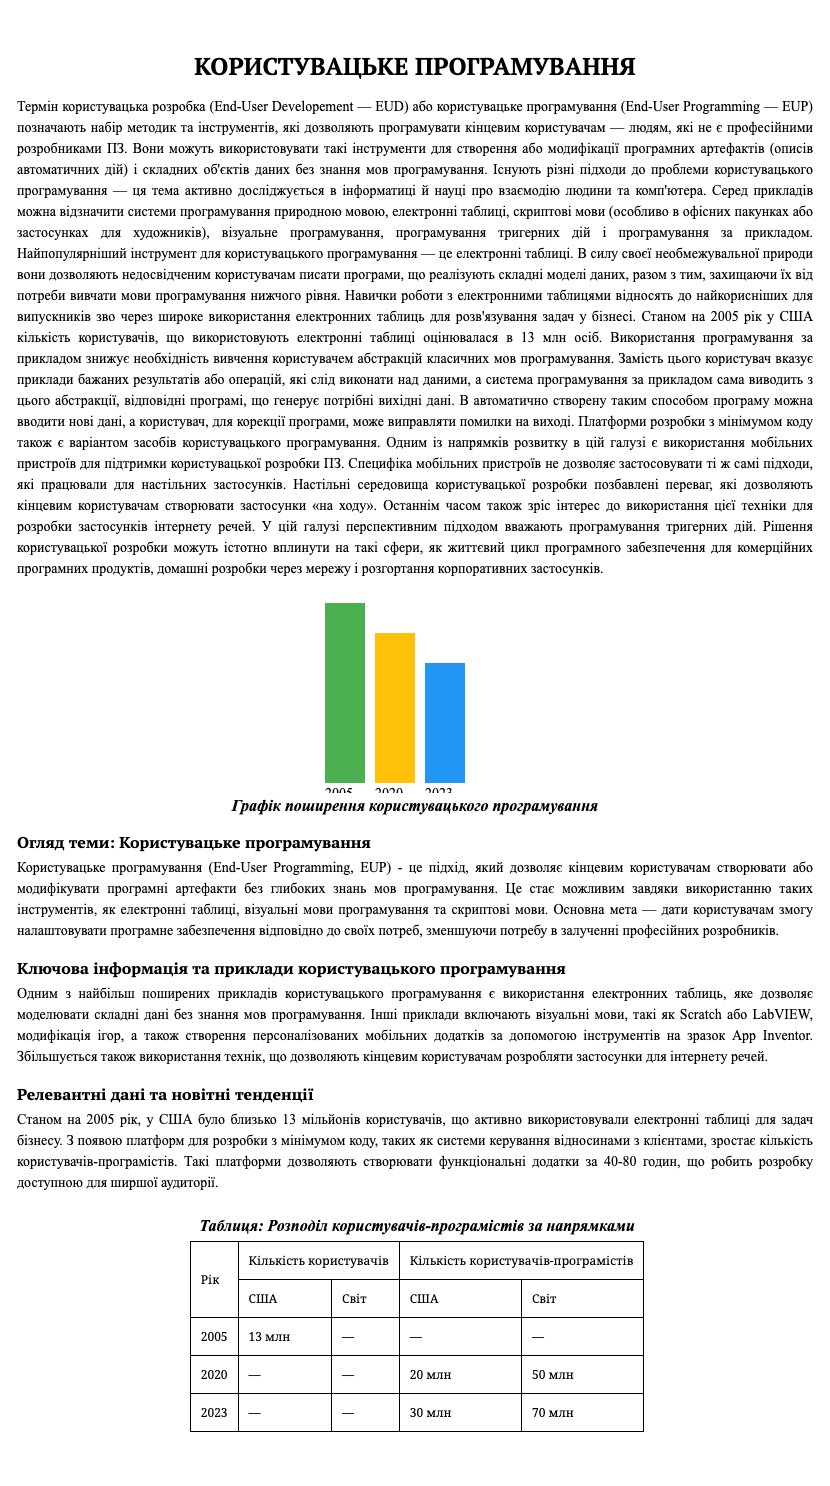

In [5]:
image

In [7]:
# instruction = "Напиши xml представлення таблиці"
instruction = pt.get_text_template()

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 4096,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

КОРИСТУВАЦЬКЕ ПРОГРАМУВАННЯ

Термін користувацька розробка (End-User Developement — EUD) або користувацьке програмування (End-User Programming — EUP) позначають набір методик та інструментів, які дозволяють програмувати кінцевим користувачам — людям, які не є професійними розробниками ПЗ. Вони можуть використовувати такі інструменти для створення або модифікації програмних артефактів (описів автоматичних дій) і складних об'єктів даних без знання мов програмування. Існують різні підходи до проблеми користувацького програмування — ця тема активно досліджується в інформатиці й науці про взаємодію людини та комп'ютера. Серед прикладів можна відзначити системи програмування природною мовою, електронні таблиці, скриптові мови (особливо в офісних пакунках або застосунках для художників), візуальне програмування, програмування тригерних дій і програмування за прикладом. Найпо популярніший інструмент для користувацького програмування — це електронні таблиці. В силу своєї необмежувальної природи

In [8]:
# instruction = "Напиши xml представлення таблиці"
instruction = pt.get_text_template()

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

output = model.generate(**inputs, max_new_tokens = 4096,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

decoded = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
decoded = "".join(decoded)

if "assistant\n" in decoded:
    decoded = decoded.split("assistant\n", 1)[1].strip()
if "<table>" in decoded:
    decoded = re.search(r"<table>.*?</table>", decoded, re.DOTALL)
    decoded = decoded.group(0) if decoded else ""

print(decoded)

КОРИСТУВАЦЬКЕ ПРОГРАМУВАННЯ

Термін користувацька розробка (End-User Development — EUD) або користувацьке програмування (End-User Programming — EUP) позначають набір методик та інструментів, які дозволяють програмувати кінцевим користувачам — людям, які не є професійними розробниками ПЗ. Вони можуть використовувати такі інструменти для створення або модифікації програмних artefactів (описів автоматичних дій) і складних об'єктів даних без знання мов програмування. Існують різні підходи до проблеми користувацького програмування — ця тема активно досліджується в інформатиці й науці про взаємодію людини та комп'ютера. Серед прикладів можна відзначити системи програмування природною мовою, електронні таблиці, скриптові мови (особливо в офісних пакунках або застосунках для художників), візуальне програмування, програмування тригнерних дій і програмування за прикладом. Найпопулярніший інструмент для користувацького програмування — це електронні таблиці. В силу своєї необмежувальної природи во

## Prompting Open-source Models

In [5]:
model = qwn.QwenVL2_LLM(
    model_name = "unsloth/Qwen2-VL-7B-Instruct",
    max_new_tokens = 4096,
    device = "cuda",
    load_in_4bit = False,
    use_gradient_checkpointing = "unsloth"
)

==((====))==  Unsloth 2025.5.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.643 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
model = phi.Phi4VisionLLM(
    model_name = "microsoft/Phi-4-multimodal-instruct",
    max_new_tokens = 1000,
    device = "cuda",
    attn_mech = "flash_attention_2"
)

Loading checkpoint shards: 100%|██████████| 3/3 [00:10<00:00,  3.60s/it]


In [ ]:
model = aya.AyaVisionLLM(
    model_name = "CohereForAI/aya-vision-8b",
    max_new_tokens = 4096,
    device = "cuda"
)

In [4]:
model = qwn.QwenVL2_LLM(
    model_name = "ansu0122/uadoc-ada-qwen2.5vl",
    max_new_tokens = 2048,
    device = "cuda",
    load_in_4bit = False
)

==((====))==  Unsloth 2025.5.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.643 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
image = dataset[-11]["image"]

model.set_prompt(pt.get_text_template())

model.stream_doc_image(image)

# if result:
#     print("result:", result)
# else:
#     print("Failed to parse the response.")

<|im_end|>


In [ ]:
# OCR Text sections
dataset = dataset.shuffle(seed=42)

model.set_prompt(pt.get_text_template())
df.ocr_dataset(dataset, "../results/ocr_text_qwen25vl_ada.jsonl", ocr_fn= model.process_doc_image, chunk_size=2, region_types=["text"])

OCR Processing chunk 1 to 2
Saved 1 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 3 to 4
Saved 2 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 5 to 6
Saved 2 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 7 to 8
Saved 0 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 9 to 10
Saved 2 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 11 to 12
Saved 1 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 13 to 14
Saved 1 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 15 to 16
Saved 2 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 17 to 18
Saved 1 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 19 to 20
Saved 2 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 21 to 22
Saved 1 records to ../results/ocr_text_qwen25vl_ada.jsonl
OCR Processing chunk 23 to 24
Saved 1 rec

In [ ]:
# OCR Doc sections
dataset = dataset.shuffle(seed=42)

model.set_prompt(pt.get_text_template())
df.ocr_dataset(dataset, "../results/ocr_whole_doc_qwen25vl_ada.jsonl", ocr_fn= model.process_doc_image, chunk_size=2)

OCR Processing chunk 1 to 2
Saved 1 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 3 to 4
Saved 2 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 5 to 6
Saved 2 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 7 to 8
Saved 0 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 9 to 10
Saved 2 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 11 to 12
Saved 1 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 13 to 14
Saved 1 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 15 to 16
Saved 2 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 17 to 18
Saved 1 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 19 to 20
Saved 2 records to ../results/ocr_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 21 to 22
Saved 1 records to ../results/ocr_whole_doc_qwen2

In [4]:
# Table Extraction Table sections
dataset = dataset.shuffle(seed=42)

model.set_prompt(pt.get_table_template())
df.ocr_dataset(dataset, "../results/table_table_qwen25vl_ada.jsonl", ocr_fn= model.process_doc_image, chunk_size=2, region_types=["table"])

OCR Processing chunk 1 to 2
Saved 1 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 3 to 4
Saved 2 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 5 to 6
Saved 2 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 7 to 8
Saved 0 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 9 to 10
Saved 2 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 11 to 12
Saved 1 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 13 to 14
Saved 1 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 15 to 16
Saved 2 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 17 to 18
Saved 1 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 19 to 20
Saved 2 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Processing chunk 21 to 22
Saved 1 records to ../results/table_table_qwen25vl_ada.jsonl
OCR Proc

In [5]:
# Table Extraction Doc sections
dataset = dataset.shuffle(seed=42)

model.set_prompt(pt.get_table_template())
df.ocr_dataset(dataset, "../results/table_whole_doc_qwen25vl_ada.jsonl", ocr_fn= model.process_doc_image, chunk_size=2)

OCR Processing chunk 1 to 2
Saved 2 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 3 to 4
Saved 1 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 5 to 6
Saved 0 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 7 to 8
Saved 1 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 9 to 10
Saved 2 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 11 to 12
Saved 1 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 13 to 14
Saved 2 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 15 to 16
Saved 1 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 17 to 18
Saved 2 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 19 to 20
Saved 1 records to ../results/table_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 21 to 22
Saved 2 records to ../results

In [6]:
# Layout Analysis Doc sections
dataset = dataset.shuffle(seed=42)

model.set_prompt(pt.get_title_template())
df.ocr_dataset(dataset, "../results/layout_whole_doc_qwen25vl_ada.jsonl", ocr_fn= model.process_doc_image, chunk_size=2)

OCR Processing chunk 1 to 2
Saved 1 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 3 to 4
Saved 2 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 5 to 6
Saved 1 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 7 to 8
Saved 1 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 9 to 10
Saved 1 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 11 to 12
Saved 1 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 13 to 14
Saved 2 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 15 to 16
Saved 2 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 17 to 18
Saved 2 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 19 to 20
Saved 2 records to ../results/layout_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 21 to 22
Saved 1 records to 

In [7]:
# Classification Doc sections
dataset = dataset.shuffle(seed=42)

model.set_prompt(pt.get_class_template())
df.ocr_dataset(dataset, "../results/class_whole_doc_qwen25vl_ada.jsonl", ocr_fn= model.process_doc_image, chunk_size=2)

OCR Processing chunk 1 to 2
Saved 1 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 3 to 4
Saved 2 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 5 to 6
Saved 1 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 7 to 8
Saved 2 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 9 to 10
Saved 1 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 11 to 12
Saved 2 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 13 to 14
Saved 2 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 15 to 16
Saved 1 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 17 to 18
Saved 2 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 19 to 20
Saved 2 records to ../results/class_whole_doc_qwen25vl_ada.jsonl
OCR Processing chunk 21 to 22
Saved 2 records to ../results

### Release Memory

In [6]:
import torch
del model 
torch.cuda.empty_cache()

In [9]:
!nvidia-smi

Thu Mar 27 19:34:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:09:00.0 Off |                  N/A |
| 30%   47C    P5             59W /  350W |     300MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024 / 1024:.2f} MB")
print(f"Memory reserved: {torch.cuda.memory_reserved() / 1024 / 1024:.2f} MB")

Memory allocated: 10.12 MB
Memory reserved: 40.00 MB
